In [28]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

print("TF  Version",tf.__version__)

TF  Version 2.4.0


## Load Data

In [2]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
RES_DIR = "/tf/notebooks/brdd/xAI_3d/data/"

OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/pictures/"

def generate_model_name(which_split, model_nr):
    return ("weights/3d_cnn_binary_model_split" + str(which_split) + 
              "_unnormalized_avg_layer_paper_model_sigmoid_activation_1" + str(model_nr) + ".h5")

/tf/notebooks/brdd/xAI_3d


In [3]:
# load images
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'

with h5py.File(path_img, "r") as h5:
    X_in = h5["X"][:]
#     Y_img = h5["Y_img"][:]
#     Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

In [4]:
# load results
path_results = RES_DIR + "all_tab_results_paper_splits.csv"
all_results = pd.read_csv(path_results, sep=",")

In [ ]:
all_results["y_pred_std"] = all_results[["y_pred_model_1" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

<AxesSubplot:xlabel='unfavorable', ylabel='y_pred_unc'>

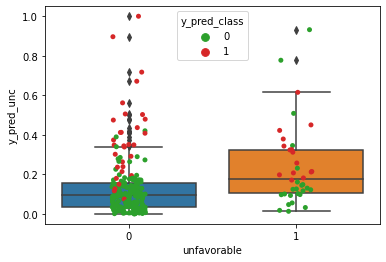

In [107]:
import seaborn as sns
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    palette=["C2", "C3"],
    data = all_results)

In [115]:
all_results["pred_ok"] = all_results["y_pred_class"] == all_results["unfavorable"] 

<AxesSubplot:xlabel='pred_ok', ylabel='y_pred_unc'>

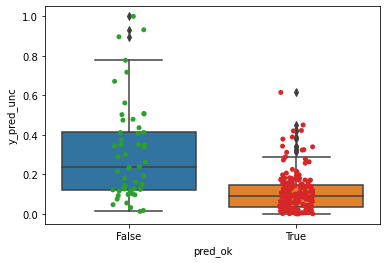

In [116]:
sns.boxplot(x = "pred_ok",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_ok",
    y = "y_pred_unc",
    palette=["C2", "C3"],
    data = all_results)

<AxesSubplot:xlabel='y_pred_trafo_avg', ylabel='y_pred_unc'>

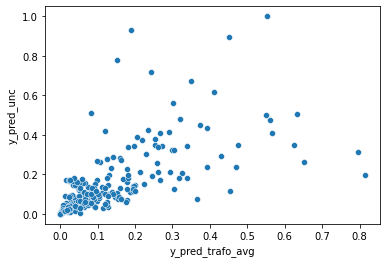

In [125]:
sns.scatterplot(
           x = "y_pred_trafo_avg",
           y = "y_pred_unc",
            data = all_results)

## Model

In [5]:
# define model
layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

input_dim = (128, 128, 28, 1)
output_dim = 1
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


## Function to calculate GradCam heatmap of ensemble

In [6]:
from functions_gradcam import multi_layers_grad_cam_3d
def multi_models_grad_cam_3d(img, cnn, model_names, layers, mode = "mean"):
    valid_modes = ["mean", "median", "max"]
    if mode not in valid_modes:
        raise ValueError("multi_models_grad_cam_3d: mode must be one of %r." % valid_modes)
        
    if not isinstance(layers, list):
        layers = [layers]
    
    h_l = []
    for model_name in model_names:
        cnn.load_weights(model_name)
        heatmap, resized_img = multi_layers_grad_cam_3d(img = img, model_3d = cnn , layers = layers)
        h_l.append(heatmap)
    
    h_l = np.array(h_l)
    if mode == "mean":
        heatmap = np.mean(h_l, axis = 0)
    elif mode == "median":
        heatmap = np.median(h_l, axis = 0)
    elif mode == "max":
        heatmap = np.max(h_l, axis = 0)
        
    return heatmap, resized_img


def get_img_and_models(p_ids, results, pats, imgs):
    imgs = np.expand_dims(imgs, axis = -1)
    
    # extract table with all matches for p_ids
    res_tab = results[results.p_id.isin(p_ids)].sort_values(["p_id", "test_split"]).reset_index()
    
    res_imgs = []
    res_mod_names = []
    
    res_test_splits = list(res_tab.test_split)
    for i, p_id in enumerate(list(res_tab.p_id)):
        index = np.argwhere(pat == p_id).squeeze()
        res_imgs.append(imgs[index])
        
        # generate model names
        res_mod_names.append(
            [generate_model_name(res_test_splits[0], j) for j in range(5)]
        )
            
    return (res_tab, np.array(res_imgs), res_mod_names)

In [102]:
p_ids = [460]

In [103]:
(res_table, res_images, res_model_names) = get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in)

In [104]:
res_table

index  p_idx   p_id  mrs  unfavorable  test_split  y_pred_model_10  \
0    230    324  460.0  4.0            1           6         0.240478   

   y_pred_model_11  y_pred_model_12  y_pred_model_13  y_pred_model_14  \
0         0.163927         0.146362         0.244161         0.217071   

   y_pred_linear_avg  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  \
0             0.2024          0.199229   0.214277             0    0.044804   

   y_pred_unc  
0    0.116549

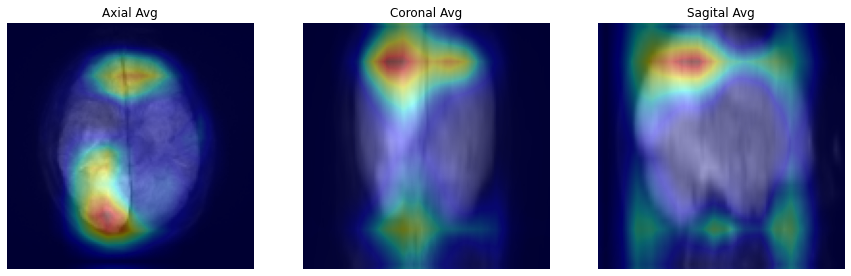

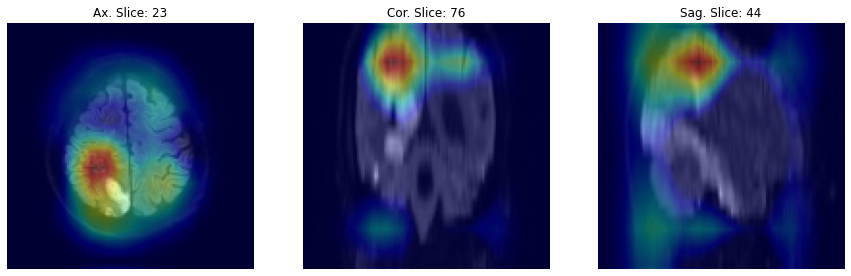

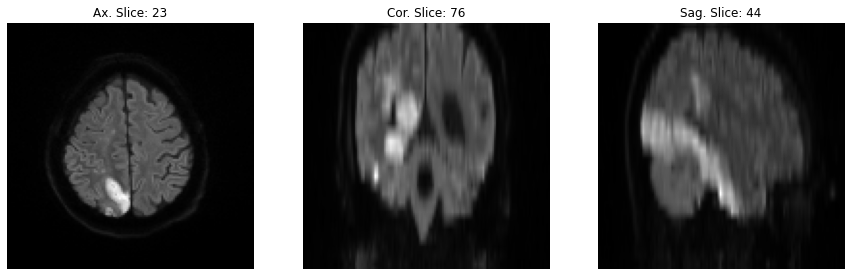

In [22]:
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][4]],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

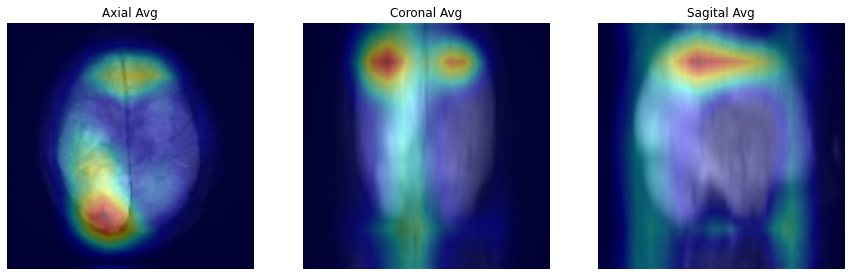

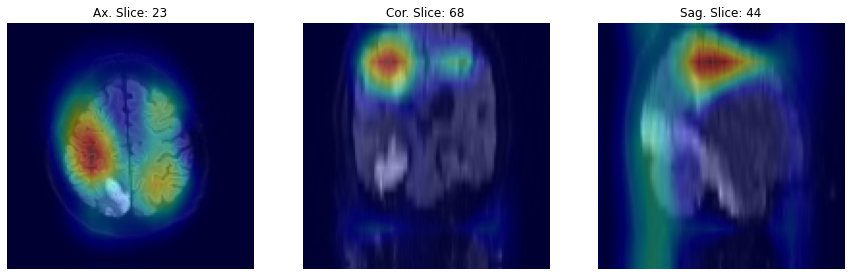

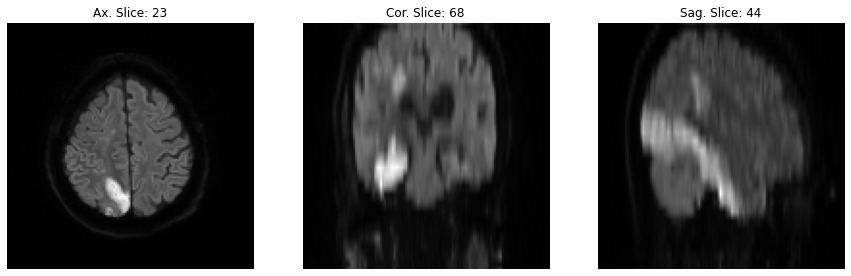

In [23]:
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

In [105]:
res_table

index  p_idx   p_id  mrs  unfavorable  test_split  y_pred_model_10  \
0    230    324  460.0  4.0            1           6         0.240478   

   y_pred_model_11  y_pred_model_12  y_pred_model_13  y_pred_model_14  \
0         0.163927         0.146362         0.244161         0.217071   

   y_pred_linear_avg  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  \
0             0.2024          0.199229   0.214277             0    0.044804   

   y_pred_unc  
0    0.116549

In [106]:
vis_layers

['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']

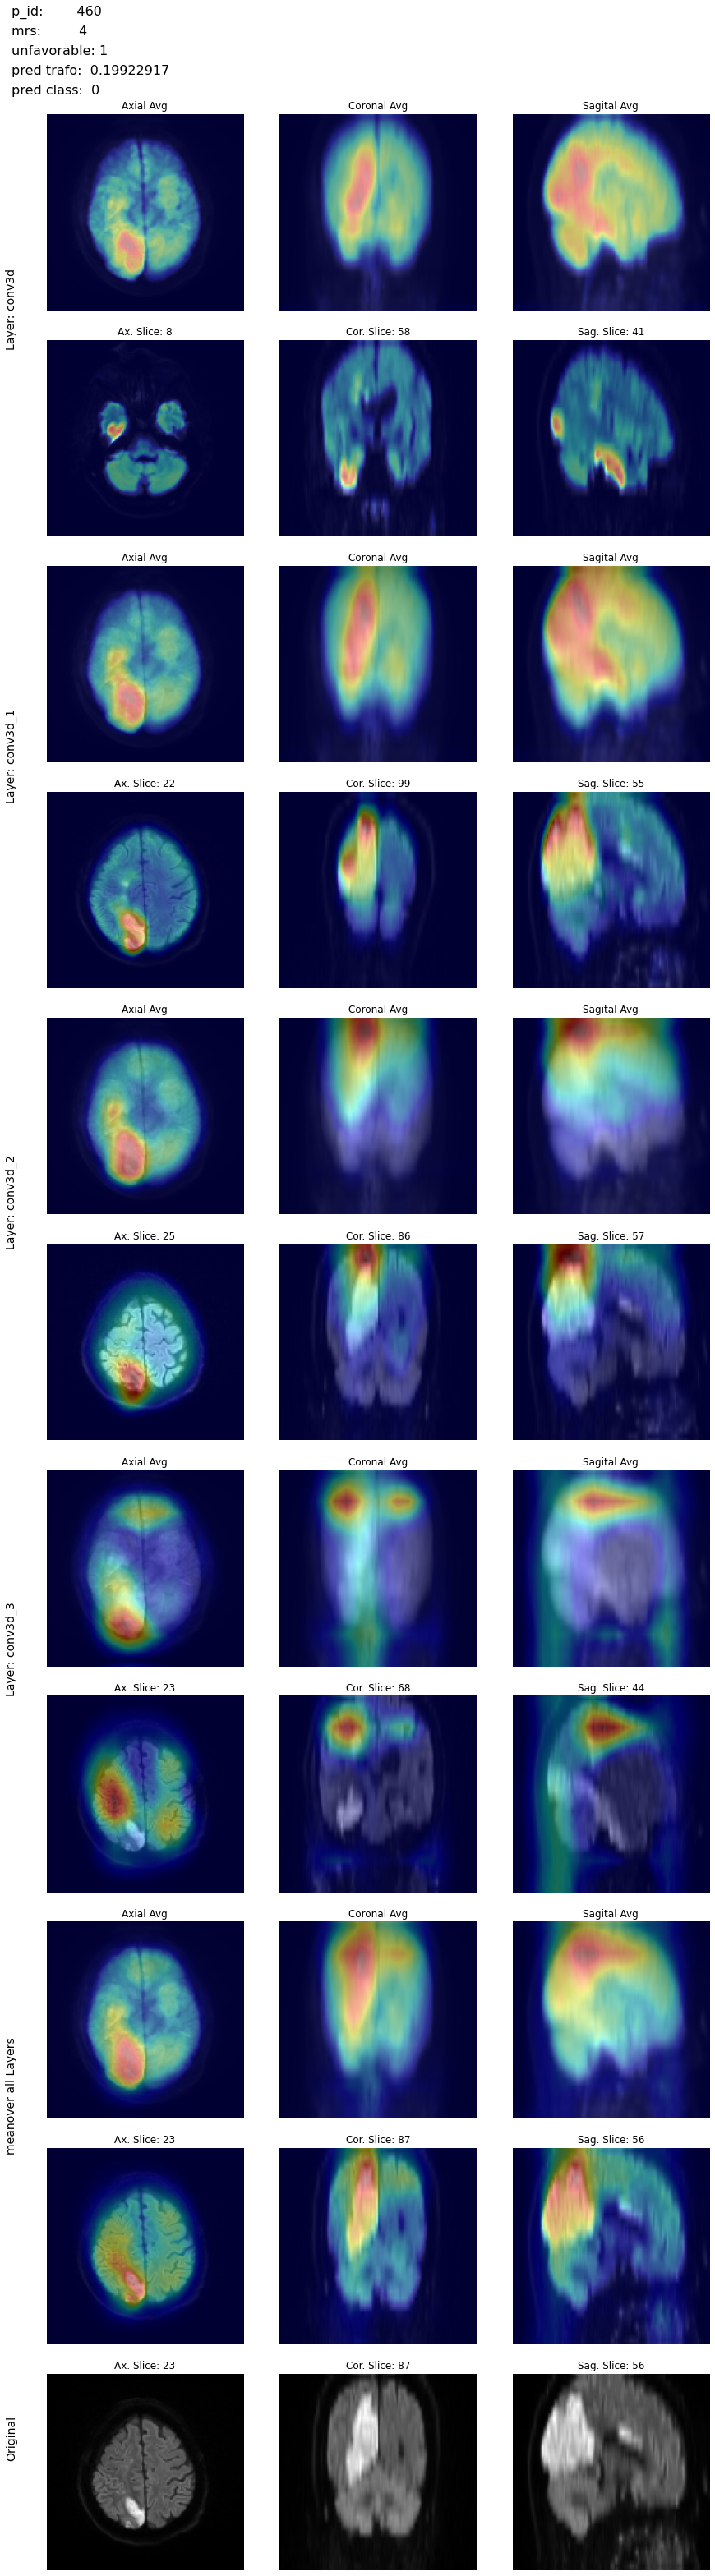

In [32]:
layer_mode = "mean"

vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

for j in range(len(res_table)):   
    plot_per_iter = 2
    plot_at_end = 1
    num_rows = len(vis_layers)*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.12
    end_text = 0.88
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.6/(num_rows-plot_at_end), 
        end_text-0.6/(num_rows-plot_at_end), 
        len(vis_layers)+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+5/num_rows/15, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+4/num_rows/15, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+3/num_rows/15, "true class: " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/15, "pred prob (class 1):  " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/15, "pred class:  " + str(res_table["y_pred_class"][j]), fontsize=16)

    for i, vis_layer in enumerate(vis_layers):
#         print("Layer: ", vis_layer)
        plt.gcf().text(0.1, text_pos[i], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
        heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layer,
            mode = layer_mode)
        
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "avg",
                     add_plot = (i*2,num_rows),
                     show = False)
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "max",
                     add_plot = (i*2+1,num_rows),
                     show = False)
        
    # average over all layers
    heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            mode = layer_mode)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + "over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (num_rows-3,num_rows),
                show = False)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (num_rows-2,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_ensembling_all_conv_layers.png')


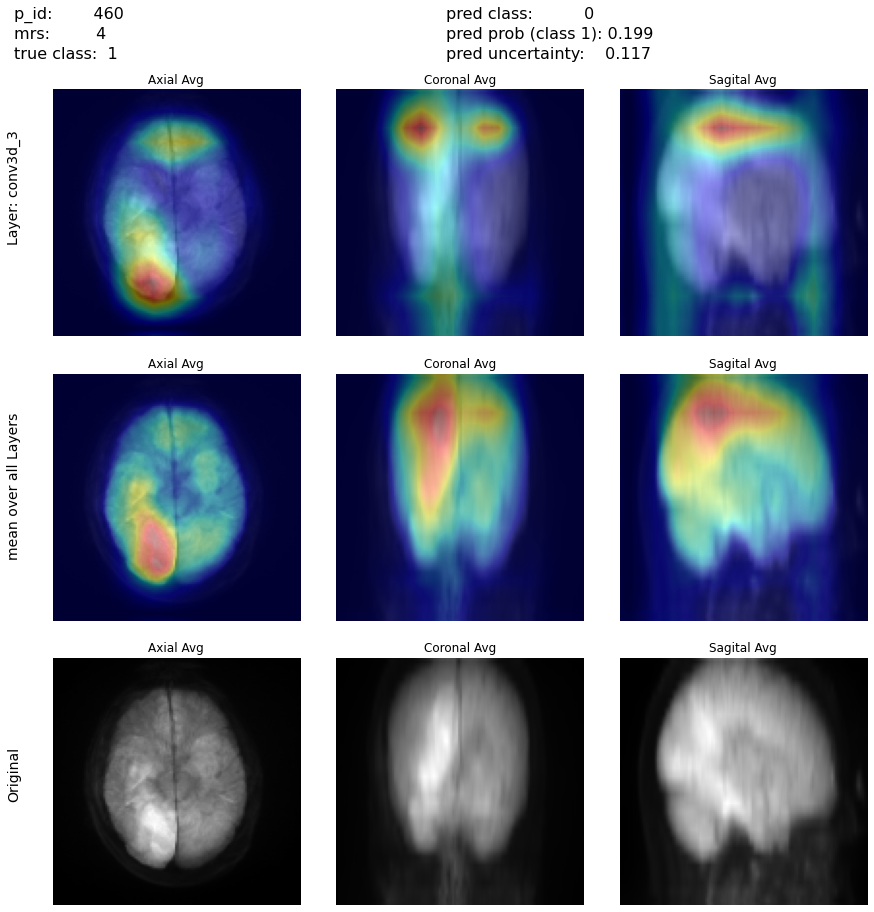

In [114]:
layer_mode = "mean"

vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

for j in range(len(res_table)):   
    plot_per_iter = 1
    plot_at_end = 1
    layer_iter = 1 #len(vis_layers)
    num_rows = layer_iter*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.08
    end_text = 0.89
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.2/(num_rows-plot_at_end), 
        end_text-0.2/(num_rows-plot_at_end), 
        layer_iter+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+3/num_rows/18, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/18, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/18, "true class:  " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.5, end_text+3/num_rows/18, "pred class:          " + str(res_table["y_pred_class"][j]), fontsize=16)
    plt.gcf().text(0.5, end_text+2/num_rows/18, "pred prob (class 1): " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.5, end_text+1/num_rows/18, "pred uncertainty:    " + str(round(res_table["y_pred_unc"][j], 3)), fontsize=16)


    # last layer
    plt.gcf().text(0.1, text_pos[0], "Layer: " + vis_layer, 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
    heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers[-1],
            mode = layer_mode)
    
    pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg",
            add_plot = (0,num_rows),
            show = False)

        
    # average over all layers
    heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            mode = layer_mode)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + " over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (1,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "avg",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_ensembling_last_and_all_layers_avg.png')


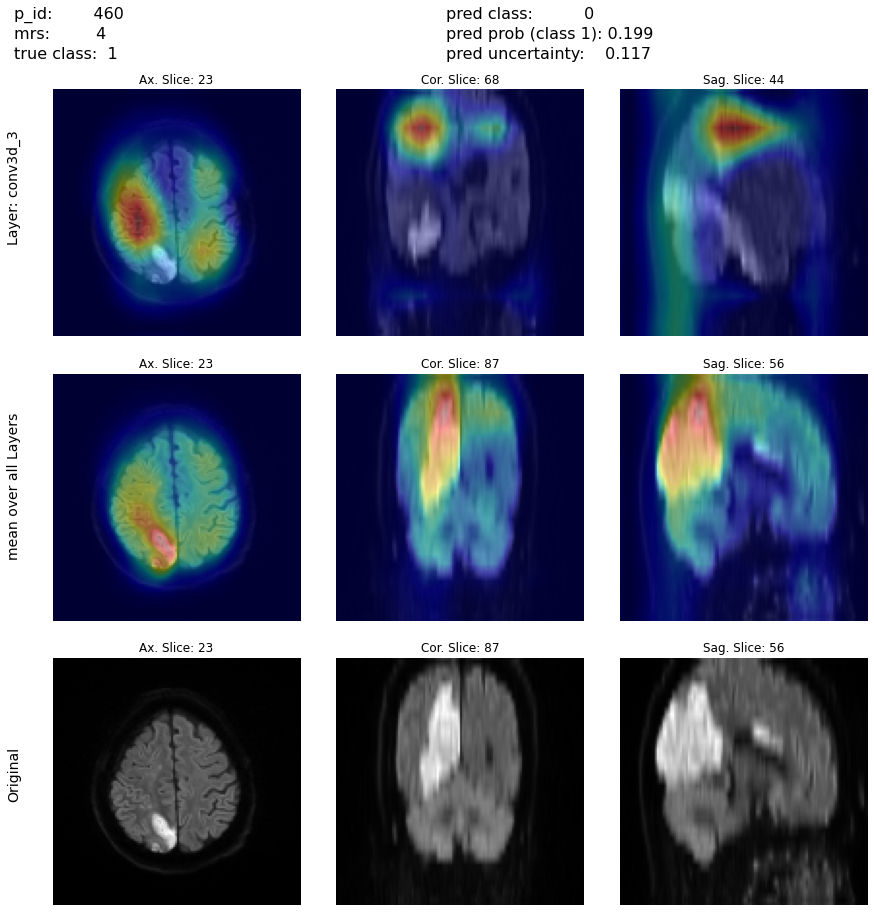

In [113]:
layer_mode = "mean"

vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

for j in range(len(res_table)):   
    plot_per_iter = 1
    plot_at_end = 1
    layer_iter = 1 #len(vis_layers)
    num_rows = layer_iter*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.08
    end_text = 0.89
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.2/(num_rows-plot_at_end), 
        end_text-0.2/(num_rows-plot_at_end), 
        layer_iter+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+3/num_rows/18, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/18, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/18, "true class:  " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.5, end_text+3/num_rows/18, "pred class:          " + str(res_table["y_pred_class"][j]), fontsize=16)
    plt.gcf().text(0.5, end_text+2/num_rows/18, "pred prob (class 1): " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.5, end_text+1/num_rows/18, "pred uncertainty:    " + str(round(res_table["y_pred_unc"][j], 3)), fontsize=16)

    # last layer
    plt.gcf().text(0.1, text_pos[0], "Layer: " + vis_layer, 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
    heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers[-1],
            mode = layer_mode)
    
    pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max",
            add_plot = (0,num_rows),
            show = False)

        
    # average over all layers
    heatmap, resized_img = multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            mode = layer_mode)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + " over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (1,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_ensembling_last_and_all_layers_max.png')


In [78]:
end_text+5/num_rows/15

0.9911111111111112

['y_pred_model_10',
 'y_pred_model_11',
 'y_pred_model_12',
 'y_pred_model_13',
 'y_pred_model_14']

In [92]:
all_results

p_idx   p_id  mrs  unfavorable  test_split  y_pred_model_10  \
0      181  239.0  2.0            0           1         0.001944   
1        3    3.0  0.0            0           1         0.066776   
2      371  515.0  2.0            0           1         0.004576   
3       49   63.0  0.0            0           1         0.084306   
4      159  215.0  2.0            0           1         0.014850   
..     ...    ...  ...          ...         ...              ...   
241    108  152.0  0.0            0           6         0.207441   
242    216  299.0  4.0            1           6         0.303313   
243    100  142.0  0.0            0           6         0.063578   
244    382  526.0  0.0            0           6         0.025847   
245    293  385.0  0.0            0           6         0.096243   

     y_pred_model_11  y_pred_model_12  y_pred_model_13  y_pred_model_14  \
0           0.007217         0.003051         0.002333         0.005528   
1           0.176739         0.357961         0.421386         0.212879   
2           0.018158         0.010685         0.002880         0.010099   
3           0.122671         0.148182         0.167622         0.364284   
4           0.046055         0.006771         0.007944         0.042364   
..               ...              ...              ...              ...   
241         0.180497         0.132671         0.142005         0.156743   
242         0.125116         0.085195         0.124809         0.102034   
243         0.063993         0.034912         0.059894         0.045131   
244         0.021198         0.014491         0.029972         0.009860   
245         0.086575         0.054529         0.111560         0.072416   

     y_pred_linear_avg  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  \
0             0.004015          0.003537   0.214277             0    0.002269   
1             0.247148          0.218066   0.214277             1    0.142570   
2             0.009280          0.007641   0.214277             0    0.006011   
3             0.177413          0.160814   0.214277             0    0.109015   
4             0.023597          0.017432   0.214277             0    0.019113   
..                 ...               ...        ...           ...         ...   
241           0.163872          0.162129   0.214277             0    0.030320   
242           0.148093          0.135341   0.214277             0    0.088375   
243           0.053502          0.052179   0.214277             0    0.012924   
244           0.020274          0.018825   0.214277             0    0.008183   
245           0.084265          0.082053   0.214277             0    0.021900   

     y_pred_unc  
0      0.004517  
1      0.374054  
2      0.014374  
3      0.285673  
4      0.048882  
..          ...  
241    0.078399  
242    0.231312  
243    0.032581  
244    0.020094  
245    0.056223  

[246 rows x 16 columns]

## Analysis of Patients in multiple splits

In [40]:
all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
all_dup

p_idx   p_id  mrs  unfavorable  test_split  y_pred_model_10  \
158      7    9.0  0.0            0           4         0.020258   
181      7    9.0  0.0            0           5         0.115826   
177     17   24.0  2.0            0           5         0.153902   
26      17   24.0  2.0            0           1         0.012346   
31      33   43.0  0.0            0           1         0.127060   
..     ...    ...  ...          ...         ...              ...   
88     382  526.0  0.0            0           3         0.002441   
235    385  529.0  5.0            1           6         0.193829   
109    385  529.0  5.0            1           3         0.014360   
170    404  556.0  0.0            0           5         0.115579   
22     404  556.0  0.0            0           1         0.000288   

     y_pred_model_11  y_pred_model_12  y_pred_model_13  y_pred_model_14  \
158         0.160626         0.091047         0.151721         0.145830   
181         0.030605         0.013851         0.124906         0.015360   
177         0.079607         0.053642         0.156859         0.169475   
26          0.038021         0.006174         0.005716         0.040173   
31          0.141026         0.302348         0.401410         0.397929   
..               ...              ...              ...              ...   
88          0.000085         0.000079         0.000294         0.000242   
235         0.138062         0.141202         0.178054         0.255392   
109         0.022577         0.006393         0.003933         0.009908   
170         0.007054         0.001242         0.132011         0.004788   
22          0.003285         0.000408         0.000086         0.000567   

     y_pred_linear_avg  y_pred_trafo_avg  threshold  y_pred_class  
158           0.113896          0.094113   0.214277             0  
181           0.060109          0.040226   0.214277             0  
177           0.122697          0.113177   0.214277             0  
26            0.020486          0.014697   0.214277             0  
31            0.273955          0.254118   0.214277             1  
..                 ...               ...        ...           ...  
88            0.000628          0.000259   0.214277             0  
235           0.181308          0.177649   0.214277             0  
109           0.011434          0.009600   0.214277             0  
170           0.052135          0.015092   0.214277             0  
22            0.000927          0.000452   0.214277             0  

[90 rows x 14 columns]

In [41]:
p_ids = [9,24]

In [42]:
(res_table, res_images, res_model_names) = get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in)

In [43]:
res_table

index  p_idx  p_id  mrs  unfavorable  test_split  y_pred_model_10  \
0    158      7   9.0  0.0            0           4         0.020258   
1    181      7   9.0  0.0            0           5         0.115826   
2     26     17  24.0  2.0            0           1         0.012346   
3    177     17  24.0  2.0            0           5         0.153902   

   y_pred_model_11  y_pred_model_12  y_pred_model_13  y_pred_model_14  \
0         0.160626         0.091047         0.151721         0.145830   
1         0.030605         0.013851         0.124906         0.015360   
2         0.038021         0.006174         0.005716         0.040173   
3         0.079607         0.053642         0.156859         0.169475   

   y_pred_linear_avg  y_pred_trafo_avg  threshold  y_pred_class  
0           0.113896          0.094113   0.214277             0  
1           0.060109          0.040226   0.214277             0  
2           0.020486          0.014697   0.214277             0  
3           0.122697          0.113177   0.214277             0

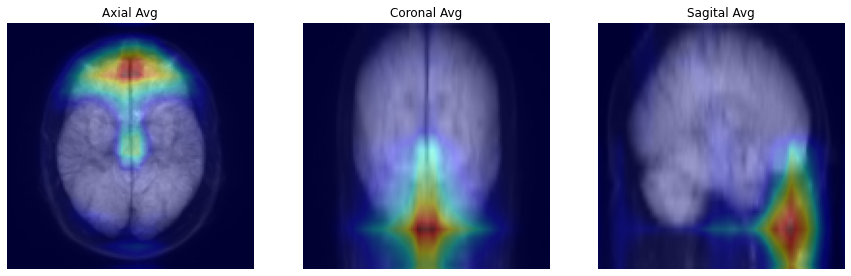

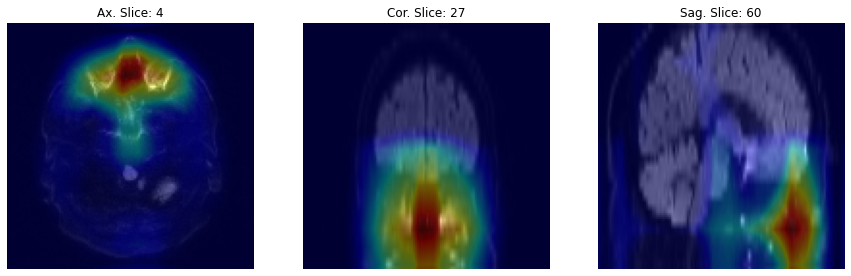

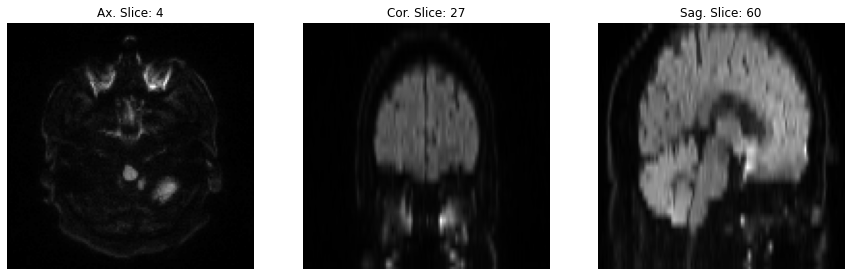

In [44]:
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

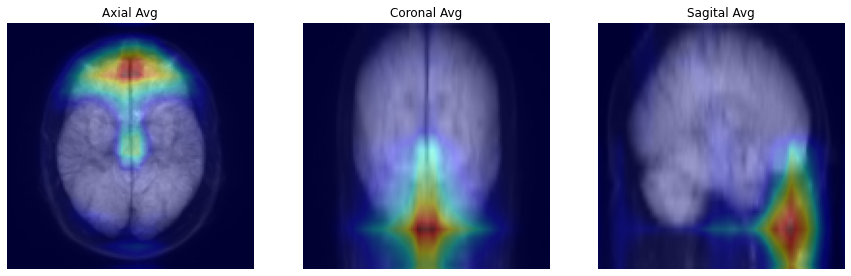

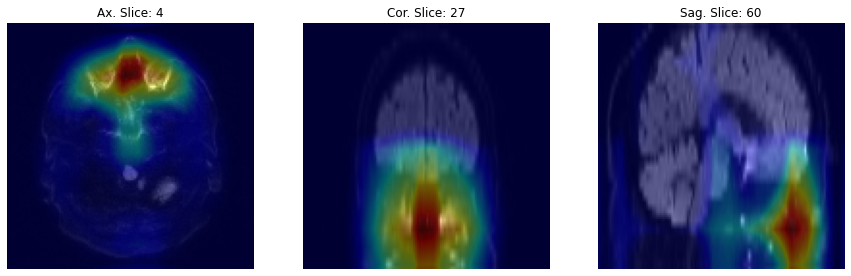

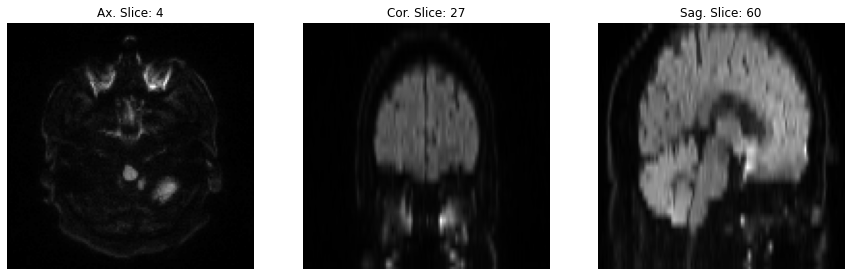

In [46]:
heatmap, resized_img = multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[1], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[1],
    layers = "conv3d_3",
    mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

### Mean Over Multiple Layers

In [18]:
results.head()

p_idx   p_id  mrs  unfavorable  pred_prob
0    372  516.0  1.0            0   0.036066
1    284  376.0  2.0            0   0.048404
2    298  390.0  2.0            0   0.137240
3    203  286.0  0.0            0   0.188111
4    292  384.0  0.0            0   0.024814

In [35]:
j = results[results.p_id == 460].index[0]
print(j)
layer_mode = "mean"

25


['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']


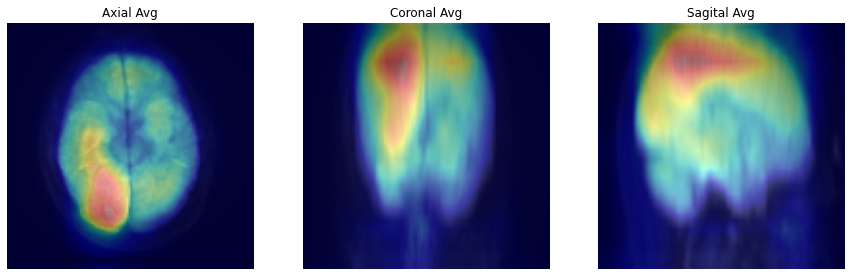

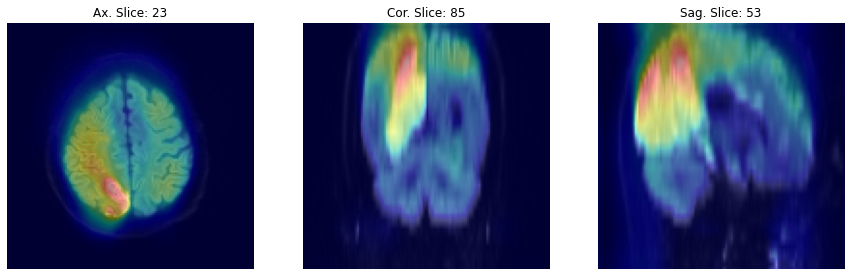

In [36]:
# conv layers only
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]
print(vis_layers)

heatmap, resized_img = gc.multi_layers_grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layers = vis_layers, mode = layer_mode)
    
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")

['conv3d', 'max_pooling3d', 'conv3d_1', 'max_pooling3d_1', 'conv3d_2', 'max_pooling3d_2', 'conv3d_3']


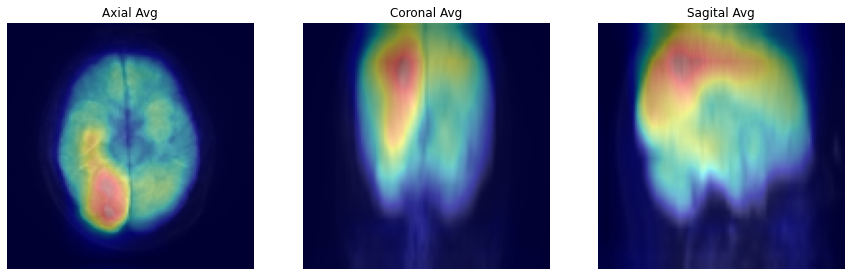

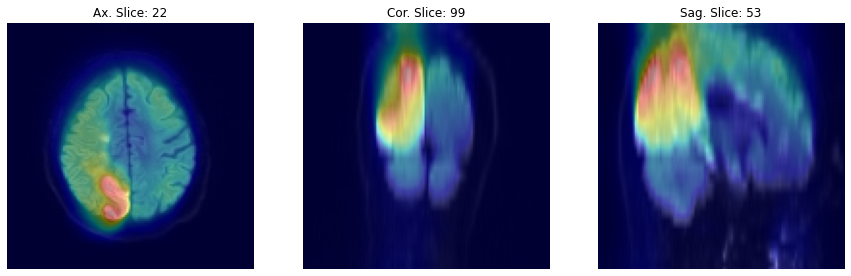

In [37]:
# all layers except last max pooling
vis_layers = [i.name for i in model_3d.layers[1:-7]]
print(vis_layers)

heatmap, resized_img = gc.multi_layers_grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layers = vis_layers, mode = layer_mode)
    
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")

conv3d_3


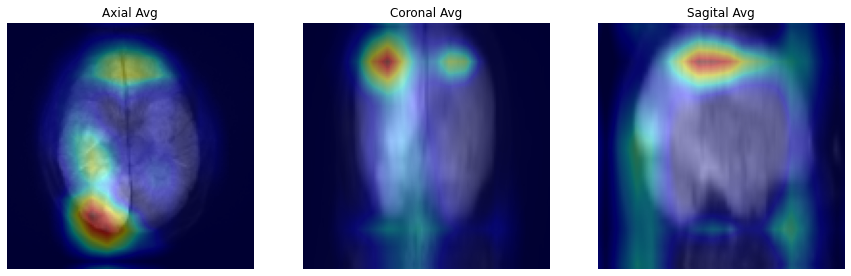

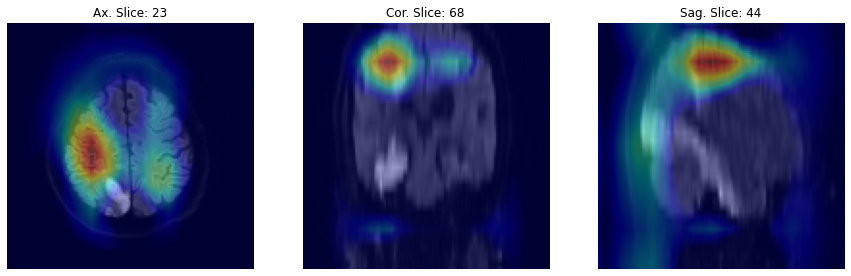

In [38]:
# last conv layer
vis_layers = 'conv3d_3'
print(vis_layers)

heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = vis_layer)
    
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")

## Average GradCam

### Choose a patient

In [24]:
for i in model_3d.layers[1:-6]:
    print(i.name)

conv3d
max_pooling3d
conv3d_1
max_pooling3d_1
conv3d_2
max_pooling3d_2
conv3d_3
max_pooling3d_3


In [25]:
# axial
which_patients = [25] #16, 24
visualization_layer_name = "conv3d_3"
pic_size = (128,128)

for j in which_patients:
    print("p_id: ", results["p_id"][j])
    print("mrs: ", results["mrs"][j])
    print("pred: ", results["pred_prob"][j])


p_id:  460.0
mrs:  4.0
pred:  0.1639269


In [26]:
heatmap, resized_img = gc.grad_cam_3d(img = X_test[j:j+1], model_3d = model_3d , layer = visualization_layer_name)

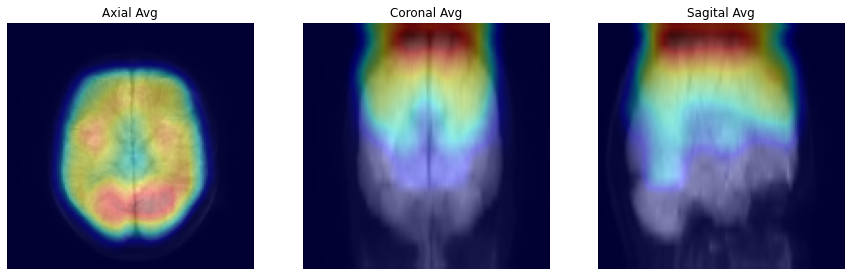

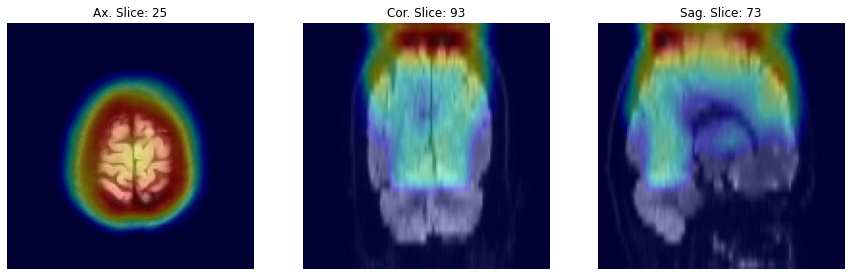

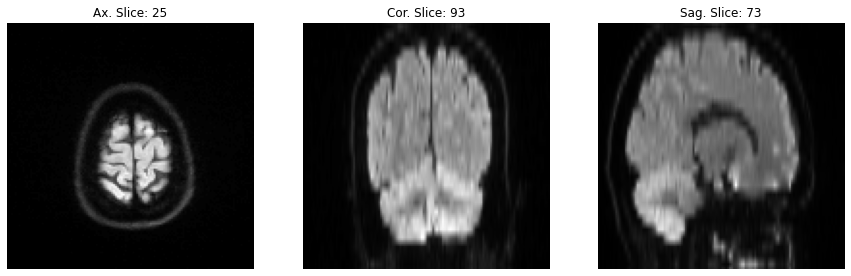

In [30]:
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")